In [42]:
import os, glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
from PIL import Image

## Feature extraction
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from keras.layers import Dense, Flatten, Input, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import mixed_precision
import IPython

# Notebook description

## Goal

In our proposal, we seek to use a CNN as a feature extractor before using classic Machine Learning algorithms to tackle the classificaiton problem.
The first step is to validate our claim that the features help improve their performance.

## Methods

For that, we pick one model and train it with raw data/CNN features, comparing both results.
We will stick with AdaBoost, and use a pre-trained ResNET50 as our feature extractors. 



### Load data and setup pre-trained ResNET50

In [43]:
# Building Training and Validation Dataframes
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

def dataframer(base_dir):
    path = []
    label = []
    for img_class in os.listdir(base_dir):
        label_path = os.path.join(base_dir, img_class)
        if img_class in labels:
            for img in os.listdir(label_path):
                path.append(os.path.join(label_path, img))
                label.append(img_class)
    img_data = pd.DataFrame({'Path': path, 'Label': label})
    return img_data

train_base_dir = "../data/seg_train"
validation_base_dir = "../data/seg_test"

train_img_data = dataframer(train_base_dir)
validation_img_data = dataframer(validation_base_dir)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    zoom_range = 0.1,
    horizontal_flip = True
)

validation_datagen = ImageDataGenerator(
    rescale = 1/255
)

# Generating Batches of the Augmented Data:
batch_size = 360

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_img_data,
    x_col="Path",
    y_col="Label",
    target_size=(150,150),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=10)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_img_data,
    x_col="Path",
    y_col="Label",
    target_size=(150,150),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False)

# Build Model
resnet = ResNet50V2(include_top=False, pooling='avg')
resnet.trainable = False # Let's start with frozen resnet weights and train just the dense

# Compile the model
resnet.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

Found 14034 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.


../data/seg_train\buildings\1012.jpg


(150, 150, 3)

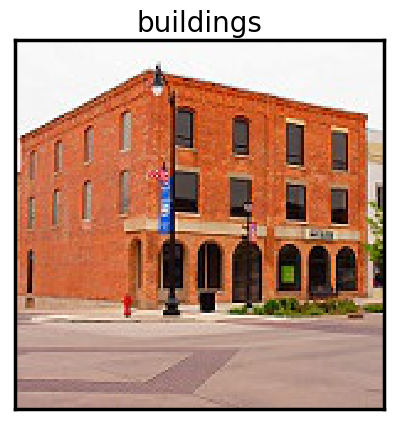

In [44]:
# Visualize the data
sample = train_img_data.iloc[10]
print(sample["Path"])
sample_img = Image.open(sample["Path"])
sample_arr = np.array(sample_img)
ax = isns.imgplot(sample_arr, map_func=np.flip, axis=0)
ax.set_title(sample["Label"])
sample_arr.shape

### Prepare features

In [46]:
def extract_features(model, data_gen):

    features = model.predict(data_gen)

    return features


train_feats = extract_features(resnet, train_generator)
validation_feats = extract_features(resnet, validation_generator)

9/9 [==============================] - 54s 6s/step


In [85]:
import pickle

with open('../models/embedding_train.pickle', 'wb') as handle:
    pickle.dump(train_feats, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../models/embedding_validation.pickle', 'wb') as handle:
    pickle.dump(validation_feats, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [59]:
print(f"Train features: {train_feats.shape}\nValidation features: {validation_feats.shape}")
print(f"Total features per image: {train_feats[0].size}")
print(f"Number of pixels features per image: {150*150*3}")

Train features: (14034, 2048)
Validation features: (3000, 2048)
Total features per image: 2048
Number of pixels features per image: 67500


### Train ADABoost using raw images

In [81]:
from sklearn import preprocessing

def load_image_data(img_dataframe, inplace=False):
    """ 
    input
    img_dataframe: Dataframe containing two collumns
        - Path: path for images
        - Label: categorical labels
    
    output
    if inplace == True:
        None
    if inplace == False:
        Dataframe containing two collumns
            - Image: numpy RBG array
            - NumericLabel: integer-valued labels 
    """

    imgs = []
    for path in img_dataframe["Path"]:
        img = Image.open(path)
        imgs.append(np.array(img).flatten())
    
    le = preprocessing.LabelEncoder()
    
    if inplace:
        img_dataframe["Image"] = imgs
        le.fit(img_dataframe["Label"])
        img_dataframe["NumericLabel"] = le.transform(img_dataframe["Label"])
        img_dataframe.drop(["Path", "Label"])
        return
    else:
        new = img_dataframe.copy()
        new["Image"] = imgs
        le.fit(new["Label"])
        new["NumericLabel"] = le.transform(new["Label"])
        new.drop(["Path", "Label"])
        return new

In [82]:
# Prepare data for training directly on images
raw_img_train = load_image_data(train_img_data)
raw_img_validation = load_image_data(validation_img_data)

KeyError: "['Path', 'Label'] not found in axis"

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

train_data = raw_img_train["Image"]
train_label = raw_img_train["NumericLabel"]


# Define pipeline for preprocessing data
preprocessing_pipeline = Pipeline([
    ("std_scaler", StandardScaler())
])

train_data = preprocessing_pipeline.fit_transform(train_data)

ValueError: setting an array element with a sequence.